101 fashion brand analysis

In [1]:
# CUDA_LAUNCH_BLOCKING=1
# TORCH_USE_CUDA_DSA=1
from resnet_model import resnet_model, Vit
from torch.utils.data import DataLoader, TensorDataset
import os
import torchvision.transforms as transforms
import numpy as np
import sklearn.metrics
import pandas as pd
import sklearn.model_selection
import torch
import torchvision
import gpytorch
import json
from pathlib import Path
import matplotlib.pyplot as plt
import PIL
import base64
from functools import cache
import wandb
import socket
import warnings
from gp_models import DirichletGPModel, MeanFieldDecoupledModel, MAPApproximateGP, OrthDecoupledApproximateGP

tensor_to_image = torchvision.transforms.ToPILImage()
pil_to_tensor = torchvision.transforms.PILToTensor()

e:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This is secret and shouldn't be checked into version control
WANDB_API_KEY= "f7759c66171682d187e02ab1f88680efdb9de31d"
# Name and notes optional
# WANDB_NAME="My first run"
# WANDB_NOTES="Smaller learning rate, more regularization."
# If you don't want your script to sync to the cloud
# os.environ["WANDB_MODE"] = "offline"

In [3]:

@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"


# Make all photos square
def pad_image(img):
    h, w = img.shape[1:]
    if h != w:
        new_w = max(h, w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w + rem_w, pad_h + rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

In [4]:
class Designer(torch.utils.data.Dataset):
    def __init__(self,
                 num_classes,
                 is_training=False,
                 data_augument=False,
                 image_transform=None,
                 data=None,
                 root=""
                 ):
        self.num_class = num_classes
        self.is_training = is_training
        self.data_augument = data_augument
        self.image_transform = image_transform
        self.data = data
        self.root = root

    def __getitem__(self, index):
        img_pth = self.data[0][index]
        label = self.data[1][index]
        img_pth = os.path.join(self.root, img_pth)
        # print(img_pth)
        image = self.pad_image(torchvision.io.read_image(img_pth, mode=torchvision.io.ImageReadMode.RGB))
        image = self.image_transform(image)
        # label = data["season_label"]
        # label_vec = np.zeros(self.num_class)
        # label_vec[label]=1
        # return image,label_vec
        return image, label, index

    def __len__(self):
        return len(self.data[0])

    # Make all photos square
    def pad_image(self, img):
        h, w = img.shape[1:]
        if h != w:
            new_w = max(h, w)
            pad_h, rem_h = divmod(new_w - h, 2)
            pad_w, rem_w = divmod(new_w - w, 2)
            padding = [pad_w, pad_h, pad_w + rem_w, pad_h + rem_h]
            return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
        return img

In [5]:
class MinibatchedDirichletClassificationLikelihood(gpytorch.likelihoods.DirichletClassificationLikelihood):
    def _shaped_noise_covar(self, base_shape, *params, selected_noise=None, **kwargs):
        assert selected_noise is not None
        if len(params) > 0:
            # we can infer the shape from the params
            shape = None
        else:
            # here shape[:-1] is the batch shape requested, and shape[-1] is `n`, the number of points
            shape = base_shape

        res = self.noise_covar(*params, shape=shape, noise=selected_noise, **kwargs)

        if self.second_noise_covar is not None:
            res = res + self.second_noise_covar(*params, shape=shape, **kwargs)
        elif isinstance(res, gpytorch.linear_operator.ZeroLinearOperator):
            warnings.warn(
                "You have passed data through a FixedNoiseGaussianLikelihood that did not match the size "
                "of the fixed noise, *and* you did not specify noise. This is treated as a no-op.",
                gpytorch.utils.warnings.GPInputWarning,
            )

        return res

In [6]:
torch.manual_seed(0)
img_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# data json

In [7]:
# 101 classes
img_root = Path('F://datasets//fashion_brands//')
train_metadata = json.loads((img_root / 'train.json').read_text())
test_metadata = json.loads((img_root / 'test.json').read_text())
val_metadata = json.loads((img_root / 'val.json').read_text())

In [8]:
# # 5 classes
# img_root = Path('F://datasets//fashion_designers_list')
# train_metadata = json.loads((img_root / 'train.json').read_text())
# test_metadata = json.loads((img_root / 'test.json').read_text())
# val_metadata = json.loads((img_root / 'val.json').read_text())
# class_labels = ["alexander_mcqueen", "donatella_versace", "john_galliano", "karl_lagerfeld", "yves_saint_laurent"]


In [9]:
n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)
n_all = n_train + n_test + n_val

all_classes = torch.empty(n_all, dtype=torch.int)
all_images_path = [None] * n_all
# all_images = [None]*n_all
for i, meta in enumerate((*train_metadata, *test_metadata, *val_metadata)):
    # print(i)
    all_classes[i] = meta['label']
    all_images_path[i] = str(img_root / meta['file_path'])

    # images
    # all_images[i] = torchvision.io.read_image(str(img_root / meta['file_path']),mode=torchvision.io.ImageReadMode.RGB)
    # all_images[i] = pad_image(torchvision.transforms.functional.resize(all_images[i], img_size, antialias=True))

n_classes = all_classes.max() + 1
print(n_classes)
# latent_dim_res = n_classes
latent_dim_res = 512  # res18
# latent_dim_res = 2048  # res50
# latent_dim_res = 768  # transformer

tensor(101, dtype=torch.int32)


In [10]:
# resnet for 101 classes
resnet_extractor = resnet_model(n_classes, backbone="resnet101").to(device)
# checkpoint = torch.load('results//fashion_brands_101_res18.3layer.bsz_128sz_224.sgd0.002//best_model.pt',
checkpoint = torch.load('results//fashion_brands_101_res101.3layer.bsz_16sz_224.sgd0.002//best_model.pt',
                        map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [11]:
# # resnet for 5 classes
# resnet_extractor = resnet_model(n_classes, backbone="resnet18").to(device)
# checkpoint = torch.load('results//fashion_designers_c5.3layer.bsz_128sz_224.sgd0.002//best_model.pt',
#                         map_location=device)
# resnet_extractor.load_state_dict(checkpoint['state_dict'])

In [12]:
for p in resnet_extractor.parameters():
    p.requires_grad = False

In [13]:
resnet_input_transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()
crop_size = resnet_input_transform.crop_size[0]
normTransform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # for the pad image function: tensor -> Image
        transforms.Resize((crop_size, crop_size)),
        transforms.ToTensor(),
        normTransform
    ]
)

# fixed train val test

In [14]:
train_classes = []
train_images_pth = []
for i, meta in enumerate(train_metadata):
    # print(i)
    train_classes.append(meta['label'])
    train_images_pth.append(str(img_root / meta['file_path']))
train_classes = torch.tensor(train_classes)
train_data = [train_images_pth, train_classes]

test_classes = []
test_images_pth = []
for i, meta in enumerate(test_metadata):
    # print(i)
    test_classes.append(meta['label'])
    test_images_pth.append(str(img_root / meta['file_path']))
test_classes = torch.tensor(test_classes)
test_data = [test_images_pth, test_classes]

print("training num:{}".format(len(train_images_pth)))
print("testing num:{}".format(len(test_images_pth)))

training num:11743
testing num:3356


# visual data distribution

In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt


In [16]:
def plot_distribution(class_array, title=''):
    grouped_data = defaultdict(list)

    # Group elements by their values
    for item in class_array:
        grouped_data[str(item.detach().numpy())].append(float(item.detach().numpy()))

    # Convert the defaultdict to a regular dictionary
    grouped_dict = dict(grouped_data)

    keys = [class_i for class_i in range(0,n_classes)]
    list_lengths = [len(grouped_dict[str(class_i)]) for class_i in range(0,n_classes)]

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.bar(keys, list_lengths, width=.5)

    # Add labels and a title
    ax.set_xlabel("brand")
    ax.set_ylabel("img_count")
    ax.set_title(title)

    # Show the plot
    plt.show()


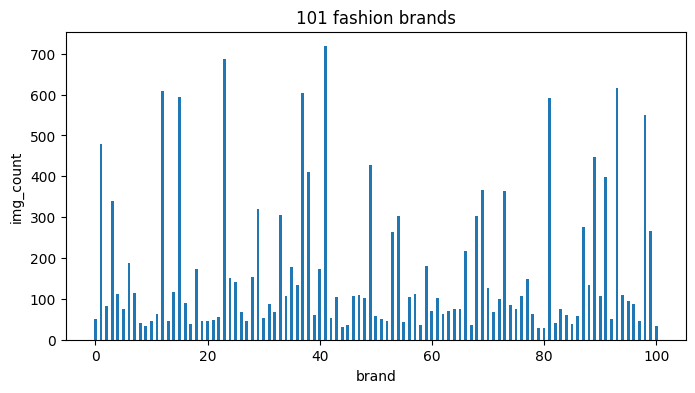

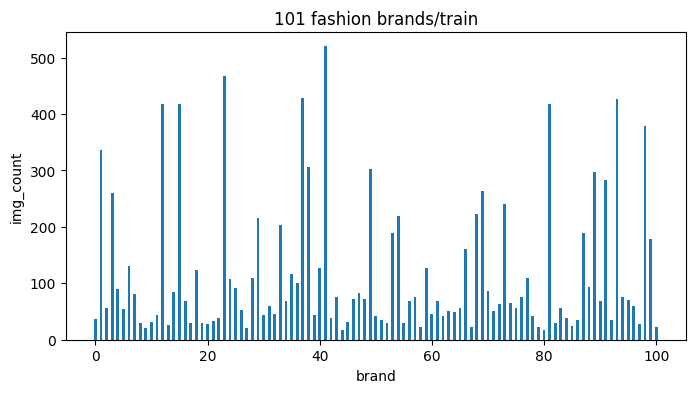

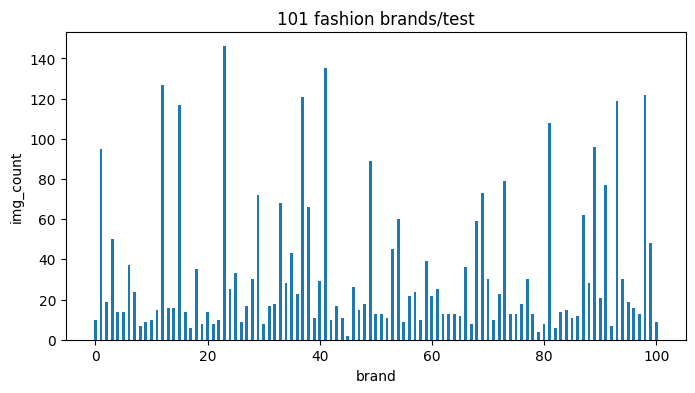

In [17]:
plot_distribution(all_classes,title='101 fashion brands')
plot_distribution(train_classes,title='101 fashion brands/train')
plot_distribution(test_classes,title='101 fashion brands/test')

# load dataset

In [18]:
batch_size = 4
train_dataset = Designer(num_classes=len(all_classes), image_transform=transform, is_training=True,
                            data_augument=False, data=train_data, root=img_root)
test_dataset = Designer(num_classes=len(all_classes), image_transform=transform, is_training=False,
                        data_augument=False, data=test_data, root=img_root)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

# testing the acc on resnet backbone

In [19]:
# test_pred_classes = torch.empty(len(test_classes), dtype=torch.int64)
# test_pred_probabilities = torch.empty(n_classes, len(test_classes), dtype=torch.float32)
# with torch.no_grad():
#     for i, (x_batch, y_batch, batch_index) in enumerate(test_loader):
#         j = (i * test_loader.batch_size)
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.to(device)

#         test_probabilities = resnet_extractor(x_batch)

#         test_probabilities = torch.nn.functional.softmax(test_probabilities, dim=1)
#         test_pred_classes[j:j + len(x_batch)] = torch.argmax(test_probabilities, dim=1, keepdim=False)
#         test_pred_probabilities[:, j:j + len(x_batch)] = test_probabilities.T

# acc = sklearn.metrics.accuracy_score(test_classes.detach().cpu(), test_pred_classes.detach().cpu())
# auc = sklearn.metrics.roc_auc_score(test_classes.detach().cpu(), test_pred_probabilities.detach().cpu().T,
#                                     multi_class="ovo")
# metrics = pd.Series(index=['acc', 'auc'])
# metrics.at['acc'] = acc
# metrics.at['auc'] = auc
# print("testing on resnet backbone:")
# print(metrics)

In [20]:
params_results = {}
num_epochs = 20
# os.environ['WANDB_NOTEBOOK_NAME'] = 'some text here'

In [21]:
for num_inducing in [900]: #[1500]: #[300,600,900,1200,1500,1800,2100]: #[300, 900, 1200]:
    # for latent_dim in [20, 15, 10, 5]:
    for latent_dim in [30]: #[3,5,10,15,20]:
        para_str = "inducing_"+str(num_inducing)+"dim_"+str(latent_dim)
        # wandb.init(
        #     # project="fashion_gp_project",
        #     project="fashion_brands",
        # )

        #define likelihood
        # likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True) #original
        likelihood = MinibatchedDirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
        # likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
        train_transformed_targets = likelihood.transformed_targets
        # train_transformed_targets = likelihood.transformed_targets.t()

        #define model
        model = OrthDecoupledApproximateGP(
            num_inducing=num_inducing,
            input_dim=latent_dim_res,
            num_classes=likelihood.num_classes,
            latent_dim=latent_dim
        )

        likelihood = likelihood.to(device)
        model = model.to(device)

        # Our loss object. We're using the VariationalELBO
        mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_classes.size(0))
        mll.to(device)
        mll.train()

        # model training
        model.train()
        initial_lengthscales = model.covar_module.base_kernel.lengthscale.numpy(force=True)
        optimization_trace = []
        optimizer = torch.optim.Adam(mll.parameters(), lr=0.01)
        step = 1
        for epoch in range(num_epochs):
            model.train()
            print("epoch: {}/{}".format(epoch, num_epochs))
            for j, (x_batch, y_batch, batch_index) in enumerate(train_loader):
                # for x_batch, y_batch in train_loader
                if j % 50 == 0:
                    print("{}/{}".format(j, str(int(len(train_loader.dataset) / batch_size) + 1)))
                optimizer.zero_grad()
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                y_batch_tf = train_transformed_targets[:, batch_index]
                y_batch_tf = y_batch_tf.to(device)
                noise_batch = likelihood.noise_covar.noise[:, batch_index]
                noise_batch = noise_batch.to(device)
                # output = model(resnet_extractor(x_batch))
                output = model(resnet_extractor.backbone(x_batch)) # resnet

                # output = resnet_extractor.model(x_batch) #transformer
                # output = model(output.last_hidden_state[:, 0]) #transformer

                # loss = -mll(output, y_batch.t()).sum(dim=0)
                # loss = -mll(output, y_batch.t()).mean(dim=0)
                full_loss = -mll(output, y_batch_tf, selected_noise=noise_batch)
                with torch.no_grad():
                    print(full_loss.mean(dim=0).item())
                    wandb.log({
                        'loss': full_loss.mean(dim=0).item(),
                        'full_loss': wandb.Histogram(full_loss.numpy(force=True)),
                        'hyper/lengthscale': wandb.Histogram(
                            model.covar_module.base_kernel.lengthscale.view(-1).numpy(force=True)),
                        'hyper/outputscale': wandb.Histogram(model.covar_module.outputscale.numpy(force=True)),
                        'hyper/second_noise': wandb.Histogram(likelihood.second_noise.view(-1).numpy(force=True)),
                        'hyper/fc_eighs': torch.linalg.eigvalsh(model.fc.weight.T @ model.fc.weight).sum().item(),
                    }, step=step)
                loss = full_loss.mean(dim=0)
                optimization_trace.append(full_loss.mean(dim=0).item())
                #optimization_trace.append(loss.item())
                loss.backward()
                optimizer.step()
                step += 1

        # test on each epoch
        model.eval()
        test_pred_classes = torch.empty(len(test_classes), dtype=torch.int64)
        test_pred_probabilities = torch.empty(n_classes, len(test_classes), dtype=torch.float32)
        with torch.no_grad():
            for i, (x_batch, y_batch, batch_index) in enumerate(test_loader):
                j = (i * test_loader.batch_size)
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                test_pred_dist = model(resnet_extractor.backbone(x_batch)) # resnet

                # output = resnet_extractor.model(x_batch)  # transformer
                # test_pred_dist = model(output.last_hidden_state[:, 0])  # transformer

                test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
                test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0)
                test_pred_classes[j:j + len(x_batch)] = torch.argmax(test_probabilities, dim=0, keepdim=False)
                test_pred_probabilities[:, j:j + len(x_batch)] = test_probabilities

        acc = sklearn.metrics.accuracy_score(test_classes.detach().cpu(), test_pred_classes.detach().cpu())
        auc = sklearn.metrics.roc_auc_score(test_classes.detach().cpu(), test_pred_probabilities.detach().cpu().T,
                                            multi_class="ovo")
        metrics = pd.Series(index=['acc', 'auc'])
        metrics.at['acc'] = acc
        metrics.at['auc'] = auc
        print(metrics)
        with torch.no_grad():
            wandb.log({
                'test/acc'+'/'+para_str: acc,
                'test/auc'+'/'+para_str: auc},step=step)
        params_results['test/acc'+'/'+para_str+'_'+str(epoch)] = acc
        params_results['test/auc'+'/'+para_str+'_'+str(epoch)] = auc

        wandb.finish()
print('all parameters results:')
print(params_results)

epoch: 0/20
